# SIR epidemic model - [data assimilation]

This notebook is the second part of inspecting SIR epidemic model. 
Here we will perform epidemic data assimilation with proposed numerical model using manually implemented 4D-Var method in TensorFlow.

## 4D-Var method

Data assimilation is the process of fitting posterior model given gathered data and prior (theoretical or based on previous measure)

TODO theory

TODO formula description

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
assert tf.__version__[0] == '2', "Tensorflow 2.x version required"

### Task 1: Complete equations according to formulas

In [3]:
def deriv(y, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Task 2: Complete the formula for each component

Hint: For accumulating results use `tf.concat`

In [4]:
def euler(deriv, y0, dt, steps, N, beta, gamma):
    S0, I0, R0 = y0
    S_result, I_result, R_result = S0, I0, R0
    for i in range(steps-1):
        S1, I1, R1 = deriv((S0, I0, R0), N, beta, gamma)
        next_s, next_i, next_r = S0 + dt*S1, I0 + dt*I1, R0 + dt*R1
        S_result = tf.concat([S_result, next_s], axis=0)
        I_result = tf.concat([I_result, next_i], axis=0)
        R_result = tf.concat([R_result, next_r], axis=0)
        S0, I0, R0 = next_s, next_i, next_r
    return S_result, I_result, R_result

In [5]:
# Total population
N = tf.constant([1000.])

# Initial infected and recovered individuals
I0, R0 = tf.constant([1.]), tf.constant([0.])

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0

# Initial conditions tuple
y0 = S0, I0, R0

# A grid of time points (in days)
days = 160
t = np.linspace(0, days, days)
dt = 1.

In [6]:
prediction = tf.constant([[0.2],[0.1]])
prior = tf.constant([[0.4],[0.1]])
B_inv = tf.eye(2)
R_inv = tf.eye(1)

In [9]:
def model_I(deriv, y0, dt, steps, N, beta, gamma):
    _, I, _ = euler(deriv, y0, dt, steps, N, beta, gamma) # X[0,0], X[1,0]
    return I[:,None,None]

In [12]:
def mm(x_pred):
    return model_I(deriv, y0, dt, days, N, x_pred[0,0], x_pred[1,0])

In [42]:
raw = mm(prediction)
data = mm(prior) + tf.random.normal([160,1,1])
y = data

In [43]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense = tf.Variable([[0.2],[0.1]])

    def call(self, inputs, training=False):
        return self.dense

In [38]:
model = MyModel()
model.weights

[<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.2],
        [0.1]], dtype=float32)>]

### Task 3: Complete the loss function according to the formula

Hint: You should use `tf.transpose` and `tf.reduce_sum`

In [39]:
# (batch_size, rows, cols)
def custom_loss(prior, x_pred):
    custom_loss = tf.transpose(x_pred-prior) @ B_inv @ (x_pred-prior) + \
      tf.reduce_sum(tf.transpose(y-mm(x_pred),perm=[0,2,1]) @ R_inv @ (y-mm(x_pred)))
    return custom_loss

In [40]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=custom_loss)

In [41]:
model.fit(prior, prior, epochs=50, batch_size=2)

Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 2844043.7500
Epoch 2/50
1/1 [==============================] - 0s 788us/step - loss: 2690215.5000
Epoch 3/50
1/1 [==============================] - 0s 946us/step - loss: 2580817.0000
Epoch 4/50
1/1 [==============================] - 0s 983us/step - loss: 2494544.5000
Epoch 5/50
1/1 [==============================] - 0s 796us/step - loss: 2411548.7500
Epoch 6/50
1/1 [==============================] - 0s 929us/step - loss: 2313411.5000
Epoch 7/50
1/1 [==============================] - 0s 773us/step - loss: 2183907.0000
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 2011284.2500
Epoch 9/50
1/1 [==============================] - 0s 826us/step - loss: 1791342.2500
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 1529370.6250
Epoch 11/50
1/1 [==============================] - 0s 1ms/step - loss: 1240200.5000
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 

## Plotting

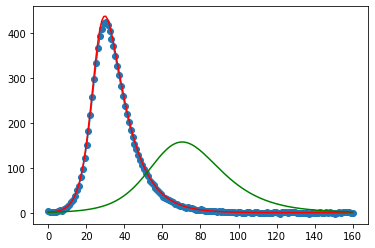

In [44]:
fig, ax = plt.subplots()
ax.plot(t, tf.squeeze(mm(prior)))
ax.plot(t, tf.squeeze(mm(model.weights[0])), color='r')
ax.plot(t, tf.squeeze(raw), color='g')
ax.scatter(t, tf.squeeze(y))

### Task 3: Perform epidemic prediction, find params that won't exceed health system capacity

In [27]:
...

Ellipsis

### Task 4: Considering lockdown level for that time estimate restrictions beta value, propose 3 other lockdown methods and assume their beta level (e.g. curfew)

In [28]:
...

Ellipsis